In [1]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras import regularizers


In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report


In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


In [4]:
import tensorflow
import sys


In [5]:
print("Python: ", sys.version)
print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Python:  3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
pandas:  1.3.4
numpy:  1.20.3
seaborn:  0.11.2
matplotlib:  3.5.0
sklearn:  1.0.1
Keras:  2.7.0
Tensorflow:  2.7.0


In [22]:
class Visualization:
    labels = ["Normal", "Anomaly"]
    
    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)
        
        plt.figure(figsize=(10, 8))
        colors = ["orange", "green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, 
                   cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
    def draw_anomaly(self, y, error, threshold):
        groupDF = pd.DataFrame({
            'error': error,
            'true': y
        }).groupby('true')
        
        figure, axes = plt.subplots(figsize=(12, 8))
        
        for name, group in groupDF:
            axes.plot(group.index, group.error,
                     marker='x' if name == 1 else 'o',
                     linestyle='', color='r' if name == 1 else 'g',
                     label="Anomaly" if name == 1 else "Normal")
            
        axes.hlines(threshold, 
                    axes.get_xlim()[0], 
                    axes.get_xlim()[1], 
                    colors="b", 
                    zorder=100, 
                    label='Threshold'
                   )
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
        
    def draw_error(self, error, threshold):
        plt.plot(error, 
                 maker='o', 
                 ms=3.5, 
                 linestyle='', 
                 label='Point'
                )
        plt.hlines(threshold,
                   xmin=0,
                   xmax=len(error)-1,
                   colors="b",
                   zorder=100,
                   label='Threshold'
                  )
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
               
        
        

In [7]:
file_path = './data/creditcard.csv'
df = pd.read_csv(filepath_or_buffer=file_path, header=0, sep=',')
print(df.shape[0])
df.head()


284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df['Amount'] = StandardScaler().fit_transform(
    df['Amount'].values.reshape(-1, 1)
)
df['Time'] = StandardScaler().fit_transform(
    df['Time'].values.reshape(-1, 1)
)
df_0 = df.query('Class == 0').sample(20000)
df_1 = df.query('Class == 1').sample(400)
df = pd.concat([df_0, df_1])
df = df.sort_values(by=['Time'], axis=0)
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
53,-1.995825,1.095525,-0.116085,1.397912,1.497547,-1.049124,0.072839,-0.723802,0.287532,0.996327,...,-0.033234,0.093262,0.089498,0.361261,0.250963,-0.378280,0.081024,0.034227,-0.344873,0
57,-1.995762,-1.330882,0.267540,-0.168470,-0.701232,3.281972,3.216390,-0.059394,0.895430,-0.017779,...,-0.151042,-0.311726,-0.374793,1.014886,0.353992,-0.510327,0.159033,0.228708,-0.297896,0
74,-1.995572,-1.793406,1.854604,0.979514,1.112262,-0.206403,-0.199546,0.616642,0.064180,0.690272,...,-0.180723,0.235138,-0.091442,0.417654,0.122734,-0.232985,0.811880,0.618568,-0.246401,0
77,-1.995551,0.921544,-0.067084,0.077461,0.953638,0.067412,0.016152,0.320452,0.038534,-0.391513,...,-0.333930,-1.299920,0.084311,-0.370398,0.155102,-0.834490,0.000909,0.035547,0.188551,0
101,-1.995151,-0.770196,0.483572,1.901072,-0.001876,0.024245,-1.171903,0.666483,-0.094603,-0.136666,...,-0.057336,-0.155801,0.018108,0.941555,-0.168582,0.056171,0.058979,0.134188,-0.263832,0


In [9]:
print(df.shape[0], df.shape[1])

20400 31


In [10]:
print(f"normal count: {len(df.query('Class == 0'))}")
print(f"anomaly count: {len(df.query('Class == 1'))}")

normal count: 20000
anomaly count: 400


In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(labels=['Time', 'Class'], axis=1), 
    df['Class'], 
    test_size=0.2,
    random_state=42
)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')


(16320, 29) train samples
(4080, 29) test samples


In [12]:
# deep autoencoder
log_file_name = "deepautoencoder"

encoding_dim = 16
input_dim = x_train.shape[1] # 29

input_arr = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_arr)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(input_arr, decoded)
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 16)                480       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 8)                 40        
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 29)                493   

2022-01-04 16:49:42.680656: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
autoencoder.compile(
    optimizer=RMSprop(),
    loss='mean_squared_error',
    metrics=['mae', 'accuracy']
)


In [14]:
batch_size = 32
epochs = 200

history = autoencoder.fit(
    x_train, 
    x_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[TensorBoard(log_dir='../logs/{0}'.format(log_file_name))]
)


Epoch 1/200
510/510 [==============================] - 1s 1ms/step - loss: 1.5418 - mae: 0.6873 - accuracy: 0.1143 - val_loss: 1.3951 - val_mae: 0.6706 - val_accuracy: 0.3039
Epoch 2/200
510/510 [==============================] - 1s 980us/step - loss: 1.4902 - mae: 0.6681 - accuracy: 0.4265 - val_loss: 1.3576 - val_mae: 0.6563 - val_accuracy: 0.4772
Epoch 3/200
510/510 [==============================] - 1s 999us/step - loss: 1.4738 - mae: 0.6616 - accuracy: 0.5097 - val_loss: 1.3504 - val_mae: 0.6534 - val_accuracy: 0.5338
Epoch 4/200
510/510 [==============================] - 0s 967us/step - loss: 1.4689 - mae: 0.6599 - accuracy: 0.5348 - val_loss: 1.3471 - val_mae: 0.6524 - val_accuracy: 0.5466
Epoch 5/200
510/510 [==============================] - 0s 977us/step - loss: 1.4659 - mae: 0.6592 - accuracy: 0.5496 - val_loss: 1.3438 - val_mae: 0.6519 - val_accuracy: 0.5684
Epoch 6/200
510/510 [==============================] - 0s 979us/step - loss: 1.4633 - mae: 0.6587 - accuracy: 0.5623 

Epoch 47/200
510/510 [==============================] - 0s 964us/step - loss: 1.4533 - mae: 0.6568 - accuracy: 0.6389 - val_loss: 1.3322 - val_mae: 0.6498 - val_accuracy: 0.6468
Epoch 48/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4533 - mae: 0.6567 - accuracy: 0.6390 - val_loss: 1.3323 - val_mae: 0.6498 - val_accuracy: 0.6512
Epoch 49/200
510/510 [==============================] - 1s 989us/step - loss: 1.4533 - mae: 0.6568 - accuracy: 0.6393 - val_loss: 1.3324 - val_mae: 0.6498 - val_accuracy: 0.6409
Epoch 50/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4533 - mae: 0.6567 - accuracy: 0.6393 - val_loss: 1.3322 - val_mae: 0.6498 - val_accuracy: 0.6500
Epoch 51/200
510/510 [==============================] - 0s 978us/step - loss: 1.4532 - mae: 0.6567 - accuracy: 0.6403 - val_loss: 1.3322 - val_mae: 0.6498 - val_accuracy: 0.6505
Epoch 52/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4532 - mae: 0.6567 - accuracy: 0.641

510/510 [==============================] - 1s 988us/step - loss: 1.4528 - mae: 0.6566 - accuracy: 0.6447 - val_loss: 1.3319 - val_mae: 0.6497 - val_accuracy: 0.6510
Epoch 94/200
510/510 [==============================] - 1s 980us/step - loss: 1.4528 - mae: 0.6567 - accuracy: 0.6431 - val_loss: 1.3317 - val_mae: 0.6497 - val_accuracy: 0.6613
Epoch 95/200
510/510 [==============================] - 0s 956us/step - loss: 1.4528 - mae: 0.6566 - accuracy: 0.6447 - val_loss: 1.3318 - val_mae: 0.6497 - val_accuracy: 0.6502
Epoch 96/200
510/510 [==============================] - 1s 996us/step - loss: 1.4528 - mae: 0.6566 - accuracy: 0.6436 - val_loss: 1.3316 - val_mae: 0.6497 - val_accuracy: 0.6576
Epoch 97/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4528 - mae: 0.6566 - accuracy: 0.6439 - val_loss: 1.3317 - val_mae: 0.6497 - val_accuracy: 0.6551
Epoch 98/200
510/510 [==============================] - 0s 931us/step - loss: 1.4528 - mae: 0.6566 - accuracy: 0.6466 - val_l

Epoch 139/200
510/510 [==============================] - 1s 995us/step - loss: 1.4526 - mae: 0.6566 - accuracy: 0.6469 - val_loss: 1.3314 - val_mae: 0.6497 - val_accuracy: 0.6613
Epoch 140/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4526 - mae: 0.6566 - accuracy: 0.6447 - val_loss: 1.3315 - val_mae: 0.6497 - val_accuracy: 0.6547
Epoch 141/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4526 - mae: 0.6566 - accuracy: 0.6470 - val_loss: 1.3314 - val_mae: 0.6496 - val_accuracy: 0.6571
Epoch 142/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4526 - mae: 0.6566 - accuracy: 0.6453 - val_loss: 1.3313 - val_mae: 0.6496 - val_accuracy: 0.6596
Epoch 143/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4526 - mae: 0.6566 - accuracy: 0.6458 - val_loss: 1.3315 - val_mae: 0.6497 - val_accuracy: 0.6532
Epoch 144/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4526 - mae: 0.6566 - accuracy: 0.6

510/510 [==============================] - 1s 1ms/step - loss: 1.4525 - mae: 0.6566 - accuracy: 0.6493 - val_loss: 1.3314 - val_mae: 0.6496 - val_accuracy: 0.6561
Epoch 186/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4525 - mae: 0.6566 - accuracy: 0.6483 - val_loss: 1.3313 - val_mae: 0.6496 - val_accuracy: 0.6574
Epoch 187/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4525 - mae: 0.6566 - accuracy: 0.6496 - val_loss: 1.3312 - val_mae: 0.6496 - val_accuracy: 0.6647
Epoch 188/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4525 - mae: 0.6566 - accuracy: 0.6478 - val_loss: 1.3312 - val_mae: 0.6496 - val_accuracy: 0.6547
Epoch 189/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4525 - mae: 0.6566 - accuracy: 0.6470 - val_loss: 1.3312 - val_mae: 0.6496 - val_accuracy: 0.6549
Epoch 190/200
510/510 [==============================] - 1s 1ms/step - loss: 1.4525 - mae: 0.6566 - accuracy: 0.6470 - val_loss: 

In [15]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])


128/128 [==============================] - 0s 688us/step - loss: 1.3313 - mae: 0.6496 - accuracy: 0.6549
Test loss:  1.3313127756118774
Test accuracy:  0.6496179699897766


In [16]:
threshold = 15.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []

for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)


In [17]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3998
           1       0.53      0.55      0.54        82

    accuracy                           0.98      4080
   macro avg       0.76      0.77      0.76      4080
weighted avg       0.98      0.98      0.98      4080



In [18]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3998
           1       0.53      0.55      0.54        82

    accuracy                           0.98      4080
   macro avg       0.76      0.77      0.76      4080
weighted avg       0.98      0.98      0.98      4080



In [19]:
roc_auc_score(y_test, y_label)

0.7693877426518138

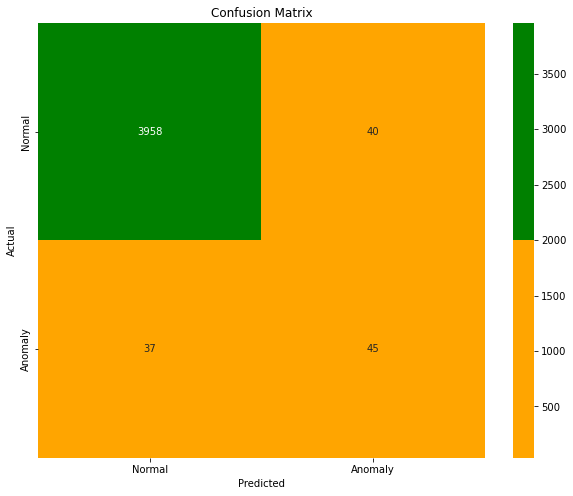

In [23]:
viz = Visualization()
viz.draw_confusion_matrix(y_test, y_label)

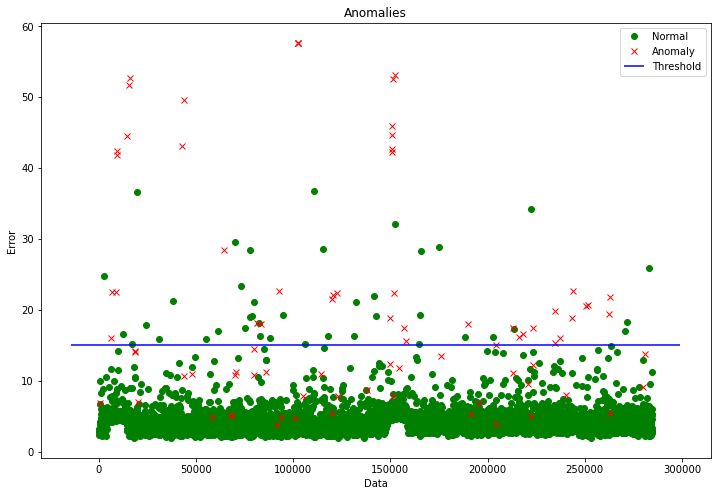

In [24]:
viz.draw_anomaly(y_test, error, threshold)